## XGBoost for Expected Goals (xG) Modeling

This notebook applies **XGBoost (Extreme Gradient Boosting)** to estimate **expected goals (xG)** using dataset **DS4**.  
XGBoost is a highly efficient and scalable implementation of **gradient boosted decision trees**, designed to deliver both accuracy and speed. 

While Random Forest aggregates many independent decision trees, XGBoost builds trees **sequentially**, where each new tree is trained to correct the errors of the previous ones.  This **boosting approach** makes the model more accurate and capable of capturing subtle patterns in the data, especially **non-linear relationships** and **complex feature interactions**.  

To remain consistent with previous models, we evaluate XGBoost using:  

- **RMSE (Root Mean Squared Error)** and **MAE (Mean Absolute Error)**, measuring prediction accuracy in absolute terms.  

- **R² (Coefficient of Determination)** and **Explained Variance**, assessing how much of the variance in the target is captured by the model.  

- **Pearson and Spearman Correlation**, quantifying the strength of linear and monotonic relationships between predicted and true values.  

- **Calibration Curve**, providing a graphical evaluation of how closely predicted probabilities align with observed values across probability bins.


#### Imports and global settings

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split

import os
import random

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Output paths
OUTPUT_DIR = "../task1_xg/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model directory
MODEL_DIR = "../task1_xg/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Setup complete. Ready to load data.")

Setup complete. Ready to load data.


####  Load dataset DS4

In [23]:
DATA_PATH = "../task1_xg/data/DS4.csv"
ds4 = pd.read_csv(DATA_PATH)

print(f"Dataset loaded: {ds4.shape[0]} rows, {ds4.shape[1]} columns")
print("Columns:", list(ds4.columns))

# Preview first rows
ds4.head()

Dataset loaded: 86833 rows, 26 columns
Columns: ['minute', 'second', 'period', 'shot_type', 'shot_technique', 'shot_body_part', 'play_pattern', 'under_pressure', 'shot_first_time', 'shot_one_on_one', 'target_xg', 'loc_x', 'loc_y', 'end_shot_x', 'end_shot_y', 'end_shot_z', 'end_shot_z_available', 'shot_from_set_piece', 'distance_to_goal', 'angle_to_goal', 'gender', 'role', 'num_players_between', 'closest_defender_dist', 'goalkeeper_positioning', 'free_proj_goal']


,minute,second,period,shot_type,shot_technique,shot_body_part,play_pattern,under_pressure,shot_first_time,shot_one_on_one,target_xg,loc_x,loc_y,end_shot_x,end_shot_y,end_shot_z,end_shot_z_available,shot_from_set_piece,distance_to_goal,angle_to_goal,gender,role,num_players_between,closest_defender_dist,goalkeeper_positioning,free_proj_goal
0,0.0435,0.8136,2,3,1,3,2,False,True,False,0.0566,0.7774,0.4366,0.6561,0.4393,0.0000,False,False,0.2143,0.1293,1,3,0.3077,0.0104,0.0132,0.7132
1,0.0507,0.6780,2,3,1,1,1,True,True,False,0.1434,0.9347,0.4166,0.9645,0.4456,0.1364,True,False,0.0871,0.2250,1,0,0.0769,0.0079,0.0123,0.3670
2,0.0797,0.1356,2,3,1,1,2,False,True,False,0.0382,0.8416,0.6964,0.8766,0.5845,0.0000,False,False,0.2227,0.0865,1,0,0.1538,0.0329,0.0068,0.5547
3,0.0942,0.2712,2,3,1,0,2,False,False,False,0.0528,0.9269,0.5910,0.8897,0.5845,0.0000,False,False,0.0995,0.1940,1,0,0.0769,0.0071,0.0045,0.5316
4,0.1159,0.0000,2,3,1,1,1,True,False,False,0.0213,0.6534,0.5295,0.6523,0.5156,0.0000,False,False,0.3301,0.0872,1,3,0.2308,0.0208,0.0019,0.7198


####  Define features, target and train/test split

In [24]:
# Define target column
target_column = "target_xg"
train_columns = [col for col in ds4.columns if col != target_column]

X = ds4[train_columns]
y = ds4[target_column]

# Check on target
print("\nTarget (xG) stats:")
print(y.describe())
print(f"Range: {y.min():.4f} - {y.max():.4f}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train.shape[0]} rows, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} rows, {X_test.shape[1]} features")


Target (xG) stats:
count   86,833.0000
mean         0.0973
std          0.1281
min          0.0002
25%          0.0275
50%          0.0540
75%          0.1060
max          0.9951
Name: target_xg, dtype: float64
Range: 0.0002 - 0.9951

Training set: 69466 rows, 25 features
Test set:     17367 rows, 25 features


#### Training the XGBoost Model

To further improve over the Random Forest model, an **XGBoost Regressor** is trained on dataset DS4.  

A **RandomizedSearchCV with 5-fold cross-validation** is used to efficiently identify the best set of hyperparameters, optimizing for **Root Mean Squared Error (RMSE)** as the main metric.  


The following hyperparameters are explored through **RandomizedSearchCV**:

- **n_estimators**: number of boosting rounds (trees) in the model. Higher values increase capacity but also risk overfitting.

- **max_depth**: maximum depth of each tree. Deeper trees capture more complex interactions but may lead to overfitting.  

- **learning_rate**: shrinkage factor applied to each tree’s contribution. Lower values slow down learning but improve generalization when combined with more trees.  

- **subsample**: fraction of the training data randomly sampled for each boosting round, adding randomness and helping to prevent overfitting.  

- **colsample_bytree**: fraction of features used when constructing each tree. Reducing this value adds diversity among trees and acts as regularization.  

- **reg_alpha (L1 regularization)**: encourages sparsity in the model weights, effectively performing feature selection.  

- **reg_lambda (L2 regularization)**: penalizes large weights, improving stability and reducing variance.  

This parameter space balances **model complexity** (max_depth, n_estimators) with **regularization** (learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda), allowing the search to identify models that are both accurate and well-generalized.



In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Define base model
xgb = XGBRegressor(
    objective="reg:squarederror",  # regression objective
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"  # faster training for large datasets
)

# Define parameter grid
param_dist = {

    # Same as RandomForestRegressor
    "n_estimators": [100, 250, 500, 1000],
    "max_depth": [None, 10, 20, 30],

    # XGBoost Specific
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 1.5, 2.0],
}

# RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=xgb,                          # XGBoost model
    param_distributions=param_dist,         # parameter distributions for hyperparameter tuning
    n_iter=30,                             # number of random combinations to try
    scoring="neg_root_mean_squared_error",  # RMSE as main metric (neg because of sklearn convention)
    cv=5,                                   # cross-validation splitting strategy
    random_state=RANDOM_STATE,              # reproducibility
    n_jobs=-1,                              # parallelization
    verbose=2                               # verbosity level, defines the amount of information displayed during training
)


# Fit
rand_search.fit(X_train, y_train)

# Best model
best_xgb = rand_search.best_estimator_
print("\nBest parameters found:", rand_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=None, n_estimators=250, reg_alpha=0.1, reg_lambda=2.0, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=None, n_estimators=250, reg_alpha=0.1, reg_lambda=2.0, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=None, n_estimators=250, reg_alpha=0.1, reg_lambda=2.0, subsample=0.6; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=None, n_estimators=250, reg_alpha=0.1, reg_lambda=2.0, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=None, n_estimators=250, reg_alpha=0.1, reg_lambda=2.0, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=250, reg_alpha=0.01, reg_lambda=2.0, subsample=0.6; total time=  15.2s
[CV] END colsample_bytree=1.0, learning_rate

In [32]:
def evaluate_predictions(y_true, y_pred, model_name="Model"):
    """
    Evaluate regression performance using a set of metrics
    suitable for probabilistic xG estimation (continuous target in [0, 1]).

    Parameters
    ----------
    y_true : array-like
        Ground truth (true xG values).
    y_pred : array-like
        Predicted xG values.
    model_name : str
        Label to display in output.

    Returns
    -------
    metrics : dict
        Dictionary of metric values.
    """

    metrics = {
        # Root Mean Squared Error (RMSE):
        # sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
        # Penalizes large errors more strongly; same units as target.
        "RMSE": root_mean_squared_error(y_true, y_pred),

        # Mean Absolute Error (MAE):
        # (1/n) * Σ |y_i - ŷ_i|
        # Robust to outliers; easy to interpret as "average absolute error".
        "MAE": mean_absolute_error(y_true, y_pred),

        # Coefficient of Determination (R²):
        # 1 - (Σ (y_i - ŷ_i)^2) / (Σ (y_i - ȳ)^2)
        # Measures proportion of variance explained by the model.
        "R2": r2_score(y_true, y_pred),

        # Explained Variance Score:
        # 1 - Var(y - ŷ) / Var(y)
        # Similar to R² but less sensitive to bias in predictions.
        "ExplainedVar": explained_variance_score(y_true, y_pred),

        # Pearson Correlation Coefficient:
        # cov(y, ŷ) / (σ_y * σ_ŷ)
        # Measures strength of linear relationship between y_true and y_pred.
        "Pearson": pearsonr(y_true, y_pred)[0],

        # Spearman Rank Correlation:
        # Pearson correlation between rank(y) and rank(ŷ)
        # Captures monotonic (not necessarily linear) relationships.
        "Spearman": spearmanr(y_true, y_pred)[0]
    }

    # Print nicely formatted results
    print(f"\n{model_name} performance:")
    for k, v in metrics.items():
        print(f"{k:>12}: {v:.4f}")

    return metrics


In [33]:
# Predict on train/test (clip to [0,1] as they are probabilities)
y_train_pred = np.clip(best_xgb.predict(X_train), 0, 1)
y_test_pred  = np.clip(best_xgb.predict(X_test),  0, 1)

# Evaluate with the same function used across models
train_metrics = evaluate_predictions(y_train, y_train_pred, "XGBoost (train)")
test_metrics  = evaluate_predictions(y_test,  y_test_pred,  "XGBoost (test)")



XGBoost (train) performance:
        RMSE: 0.0274
         MAE: 0.0148
          R2: 0.9537
ExplainedVar: 0.9537
     Pearson: 0.9771
    Spearman: 0.9754

XGBoost (test) performance:
        RMSE: 0.0394
         MAE: 0.0193
          R2: 0.9093
ExplainedVar: 0.9093
     Pearson: 0.9542
    Spearman: 0.9715


#### Calibration Analysis

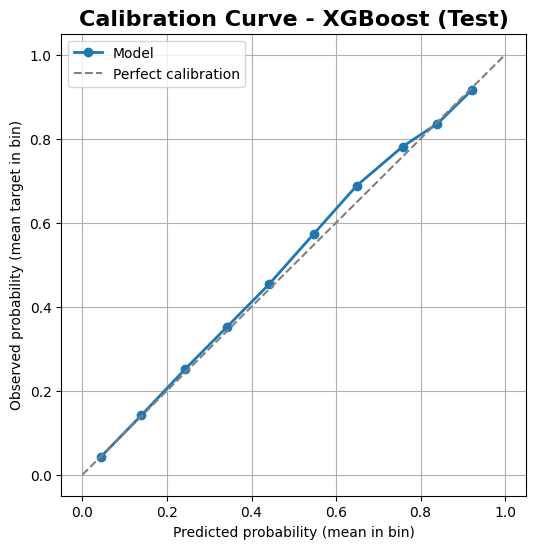

In [34]:
def plot_calibration_continuous(y_true, y_pred, n_bins=10, title="Calibration Curve"):
    # Create bins based on predicted probabilities
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_pred, bins) - 1

    bin_true = []
    bin_pred = []

    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):
            bin_true.append(y_true[mask].mean())
            bin_pred.append(y_pred[mask].mean())

    # Plot calibration
    plt.figure(figsize=(6, 6))
    plt.plot(bin_pred, bin_true, marker='o', label="Model", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")

    plt.xlabel("Predicted probability (mean in bin)")
    plt.ylabel("Observed probability (mean target in bin)")
    plt.title(title, fontsize=16, fontweight="bold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run calibration plot on test set
plot_calibration_continuous(y_test.values, y_test_pred, n_bins=10, 
                            title="Calibration Curve - XGBoost (Test)")


#### Features Importance

In [35]:
def plot_feature_importance(df, title="Feature Importance", top_n=None):
    """
    Plot feature importance for any model in a standardized way.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns: ['feature', 'importance'] and optionally ['sign'].
        - importance should be normalized to [0,1].
        - sign (optional) should be +1 or -1 to indicate direction of effect.
    title : str
        Title of the plot.
    top_n : int or None
        If set, show only the top N features.
    """

    # Sort by importance
    df = df.sort_values(by="importance", ascending=False)

    # Keep only top_n if requested
    if top_n is not None:
        df = df.tail(top_n)

    # Choose color palette
    if "sign" in df.columns:
        # Diverging colors based on sign
        colors = df["sign"].map({1: "steelblue", -1: "indianred"})
    else:
        # Single-color palette
        colors = "steelblue"

    # Plot
    plt.figure(figsize=(10, max(6, len(df)//3)))
    sns.barplot(data=df, x="importance", y="feature", palette=colors if isinstance(colors, list) else None)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

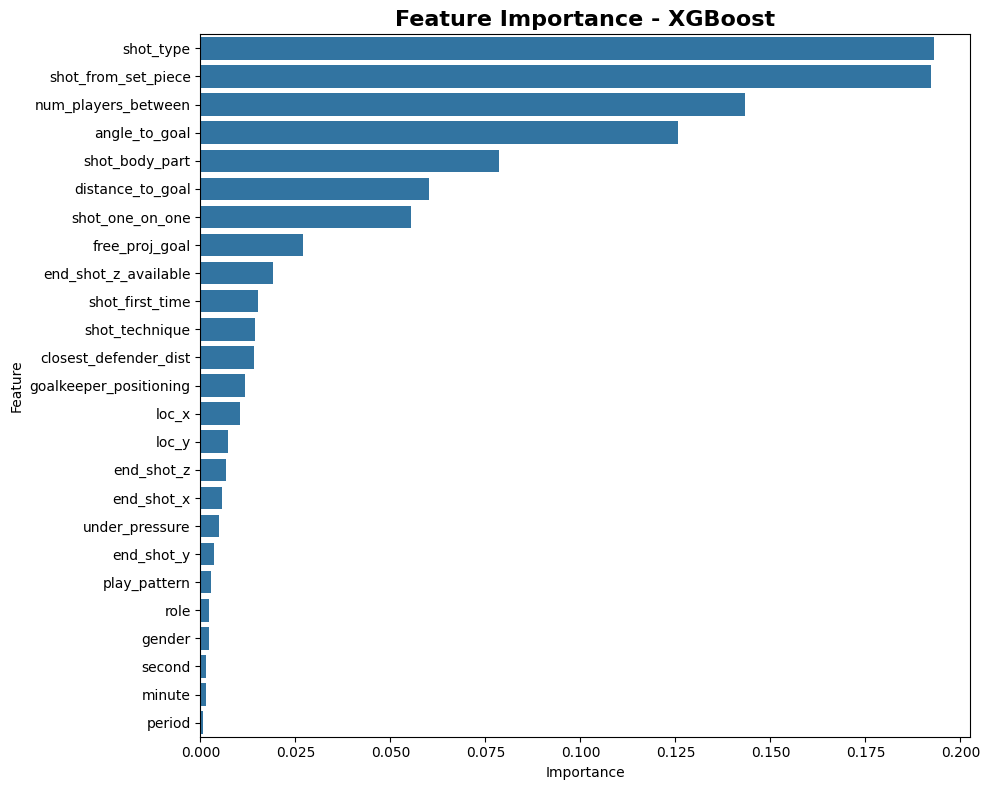

In [36]:
# XGBoost exposes importances via the sklearn API
imp_raw = best_xgb.feature_importances_

xgb_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": imp_raw,
    "sign": 1  # boosting trees don't have a sign like linear models
}).sort_values(by="importance", ascending=True)

# Plot (reuse your universal plotter)
plot_feature_importance(xgb_importance, title="Feature Importance - XGBoost")


#### Save results and trained model

In [37]:
import joblib

# Save metrics (test set)
results_df = pd.DataFrame([test_metrics], index=["XGBoost (test)"])
results_df.to_csv(f"{OUTPUT_DIR}/metrics_xgb.csv", index=True)

# Save model
joblib.dump(best_xgb, f"{MODEL_DIR}/model_xgb.pkl")


print(f"Metrics saved to {OUTPUT_DIR}/metrics_xgb.csv")
print(f"Models saved to {MODEL_DIR}/model_xgb.pkl and {MODEL_DIR}/model_xgb.json")


Metrics saved to ../task1_xg/outputs/metrics_xgb.csv
Models saved to ../task1_xg/models/model_xgb.pkl and ../task1_xg/models/model_xgb.json


## Conclusions

The **XGBoost Regressor** returns strong predictive performance on the xG estimation task.  
On the **training set**, the model achieves an **RMSE of 0.0274** and an **R² of 0.9537**, while on the **test set** it maintains high generalization with an **RMSE of 0.0394** and an **R² of 0.9093**. These results indicate that XGBoost successfully balances **model complexity and regularization**.

The **feature importance analysis** highlights the dominant role of contextual variables such as **shot type**, **set piece origin**, **number of players between shooter and goal**, and **angle to goal**.  

Moreover, the **calibration curve** shows that the predicted probabilities are well aligned with observed outcomes across all bins, confirming that the model produces reliable probability estimates.  